# Task 2: Model Building and Training

Objective:
Build, train, and evaluate machine learning models for fraud detection
using techniques suitable for highly imbalanced datasets.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    average_precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

RANDOM_STATE = 42


In [2]:
fraud_df = pd.read_csv("../data/processed/fraud_processed.csv")
credit_df = pd.read_csv("../data/processed/creditcard_processed.csv")


In [3]:
# Fraud (E-commerce) dataset
X_fraud = fraud_df.drop(columns=["class"])
y_fraud = fraud_df["class"]

# Credit card dataset
X_credit = credit_df.drop(columns=["Class"])
y_credit = credit_df["Class"]


In [4]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_fraud, y_fraud,
    test_size=0.2,
    stratify=y_fraud,
    random_state=RANDOM_STATE
)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_credit, y_credit,
    test_size=0.2,
    stratify=y_credit,
    random_state=RANDOM_STATE
)


In [5]:
smote = SMOTE(random_state=RANDOM_STATE)

Xf_train_res, yf_train_res = smote.fit_resample(Xf_train, yf_train)
Xc_train_res, yc_train_res = smote.fit_resample(Xc_train, yc_train)

print("Fraud class distribution after SMOTE:")
print(np.bincount(yf_train_res))


Fraud class distribution after SMOTE:
[93502 93502]


In [6]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc_pr = average_precision_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name}")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"F1-score: {f1:.4f}")

    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    return auc_pr, f1



Logistic Regression (Fraud Data)
AUC-PR: 0.0981
F1-score: 0.1620


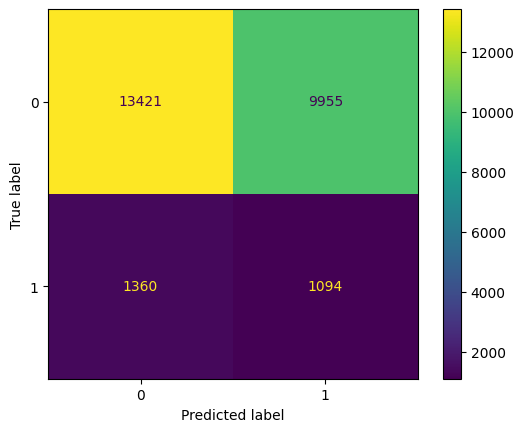

In [7]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

log_reg.fit(Xf_train_res, yf_train_res)

lr_auc, lr_f1 = evaluate_model(
    log_reg,
    Xf_test,
    yf_test,
    "Logistic Regression (Fraud Data)"
)



Random Forest (Fraud Data)
AUC-PR: 0.6371
F1-score: 0.6897


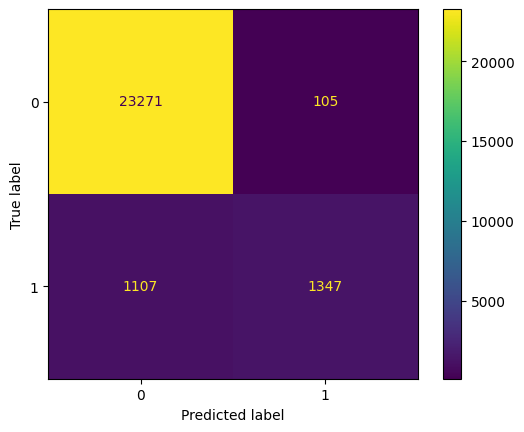

In [8]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(Xf_train_res, yf_train_res)

rf_auc, rf_f1 = evaluate_model(
    rf,
    Xf_test,
    yf_test,
    "Random Forest (Fraud Data)"
)


In [9]:
def cross_val_scores(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    scoring = {
        "auc_pr": "average_precision",
        "f1": "f1"
    }

    scores = cross_validate(
        model,
        X,
        y,
        cv=skf,
        scoring=scoring,
        n_jobs=-1
    )

    return {
        "AUC-PR Mean": scores["test_auc_pr"].mean(),
        "AUC-PR Std": scores["test_auc_pr"].std(),
        "F1 Mean": scores["test_f1"].mean(),
        "F1 Std": scores["test_f1"].std()
    }


In [10]:
lr_cv = cross_val_scores(log_reg, Xf_train_res, yf_train_res)
rf_cv = cross_val_scores(rf, Xf_train_res, yf_train_res)

pd.DataFrame([lr_cv, rf_cv], index=["Logistic Regression", "Random Forest"])


,AUC-PR Mean,AUC-PR Std,F1 Mean,F1 Std
Logistic Regression,0.501766,0.002298,0.461415,0.004948
Random Forest,0.947885,0.001063,0.805688,0.001535


## Model Comparison & Selection

Random Forest outperforms Logistic Regression in both AUC-PR and F1-score.
Given the cost of missing fraudulent transactions, Random Forest is selected
as the final model despite lower interpretability.


In [11]:
pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "AUC-PR": [lr_auc, rf_auc],
    "F1-score": [lr_f1, rf_f1]
})


,Model,AUC-PR,F1-score
0,Logistic Regression,0.098137,0.162038
1,Random Forest,0.637072,0.689708


In [12]:
import joblib

joblib.dump(rf, "../models/random_forest_fraud.pkl")


['../models/random_forest_fraud.pkl']